# Evaluating Algorithms for Imbalanced Data

* Student Name: Michael Rideout
* Student Number: 225065259
* E-mail: s225065259@deakin.edu.au
* Student Course Code: SIT731
---

## Introduction

The purpose of this investigation how differing imbalance ratios on synthetically generated affect the performance of machine learning algorithms specifically designed to handle imbalanced data. Imbalanced data is a common occurance in data science where one class (the majority class) significantly outnumbers other classes. Such imbalances can lead to biases in the model and result in poor performance, especially for the minority class(es). It is therefore, crucial to address data imbalances correctly.

Based on the methodology outlined in Aguiar et al. [1], we analyse six different classification algorithms that are designed to handle imbalanced data using synthetically generated data or varying imbalance ratios. We employ three performance metrics to determine if changes in performance occurr across differing evaluation metrics.

In [1]:
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import compute_sample_weight
from sklearn.datasets import make_classification


!pip install imblearn
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.over_sampling import RandomOverSampler


!pip install river
from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing
from river import compose
from river import tree, ensemble, forest


## Dataset
In order to evaluate differing imbalance ratios on classification performance, a means to vary imbalance ratios was required. Synthetic datasets provide a way to control the imbalance ratio when generated. A synthetic dataset is a collection of data that is generated via artificial means. 
Synthetic datasets with 10,000 sample having 20 features were generate with imbalance ratios of 5, 10, 20, 50 and 100. Scikit Learn's make_classification function was employed to generate the datasets.

The imbalance ratio is the proportion of the minority class to the majority class. For example, an imbalance ration of 20:1 means that for every instance of the minority class, twenty instances of the majority class were generated.


In [2]:
class SyntheticDatasetGenerator():

    def generate_dataset(self, row_count, imbalance_ratio):
        """
        Generate a synthetic dataset with a specified number of rows and imbalance ratio.
        """
        majority_class_weight = imbalance_ratio / (imbalance_ratio + 1)
        minority_class_weight = 1 / (imbalance_ratio + 1)
        X, y = make_classification(n_samples=row_count, n_features=20, random_state=42, weights=[minority_class_weight, majority_class_weight])

        df = pd.DataFrame(X, columns=[f'feature_{i+1}' for i in range(X.shape[1])]) 
        df['label'] = y
        return df
        

## Classifiers
Six classifiers in total where chosen to be evaluated, all of which have the mechanisms to handle imbalanced data.
The six classifiers that were chosen are:
|Classifier|Description|
|----------|-----------|
|Balanced Random Forest Classifier|Uses undersampling to balance each tree's boostrapped data|
|Adaptive Random Forest|An online ensemble method that adapts to changes in data distribution over time|
|Leverage Bagging|An ensemble classifier that combines bagging with an adaptive weighting scheme|
|Random Over Sample Examples|A data level approach that oversamples the minority class by generating synthetic examples. After oversample is performed, a Balanced Random Forest Classifier is used for classification|
|Easy Ensemble|A data level method that undersamples the majority class by creating multiple balanced subsets of the data|
|RUSBoost|Combines undersampling of the majority class with boosting|


In [3]:
# The base classifier. Subclasses should implement fit and predict methods.
class BaseClassifier:

    def __init__(self, algorithm_name, target_column_name) -> None:
        self.algorithm_name = algorithm_name
        self.target_column_name = target_column_name

    
    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        pass

    def predict(self, test_data: pd.DataFrame):
        pass

    def calculate_g_mean(self, y_true, y_pred):
        """
        Calculate the G-mean
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        num_positives = np.sum(y_true)
        num_negatives = len(y_true) - num_positives
        
        true_positives = np.sum(np.logical_and(y_true == 1, y_pred == 1))
        true_negatives = np.sum(np.logical_and(y_true == 0, y_pred == 0))
        false_positives = np.sum(np.logical_and(y_true == 0, y_pred == 1))
        false_negatives = np.sum(np.logical_and(y_true == 1, y_pred == 0))

        sensitivity = true_positives / num_positives
        specificity = true_negatives / num_negatives
        g_mean = np.sqrt(sensitivity * specificity)
        
        return g_mean

    def calculate_auc(self, y_true, y_pred):
        """
        Calculate the area under the curve
        """
        return roc_auc_score(y_true, y_pred)


    def calculate_kappa(self, y_true, y_pred):
        """
        Calculate the Cohen's kappa coefficient.
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        
        confusion = confusion_matrix(y_true, y_pred)
        observed_agreement = np.trace(confusion) / np.sum(confusion)
        expected_agreement = np.sum(np.sum(confusion, axis=0) * np.sum(confusion, axis=1)) / np.sum(confusion)**2
        kappa = (observed_agreement - expected_agreement) / (1 - expected_agreement)
        
        return kappa * 100

    
    def evaluate(self, dataset: pd.DataFrame):
        # split the dataset
        train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
        self.fit(dataset, train_data)
        y_true = test_data[self.target_column_name]
        y_pred = self.predict(test_data)
        kappa = self.calculate_kappa(y_true, y_pred)
        auc = self.calculate_auc(y_true, y_pred)
        gmean = self.calculate_g_mean(y_true, y_pred)
        return {"auc": auc, "kappa": kappa, "gmean": gmean}



In [4]:
# BalancedRandomForestClassifier
class BalancedRandomForestClassifierWrapper(BaseClassifier):

    def __init__(self, algorithm_name, target_column_name) -> None:
        super().__init__(algorithm_name, target_column_name)
        self.clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
    
    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        train_df = train_data
        x_train = train_df.drop(columns=[self.target_column_name])
        y_train = train_df[self.target_column_name]
        self.clf.fit(x_train, y_train)

    def predict(self, test_data: pd.DataFrame):
        return self.clf.predict(test_data.drop(columns=[self.target_column_name]))

In [5]:
# Easy Ensemble Classifier
class EasyEnsembleClassifierWrapper(BaseClassifier):
    def __init__(self, algorithm_name, target_column_name) -> None:
        super().__init__(algorithm_name, target_column_name)
        self.clf = EasyEnsembleClassifier(n_estimators=10, random_state=42)

    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        x_train = train_data.drop(columns=[self.target_column_name])
        y_train = train_data[self.target_column_name]
        self.clf.fit(x_train, y_train)

    def predict(self, test_data: pd.DataFrame):
        return self.clf.predict(test_data.drop(columns=[self.target_column_name]))

In [6]:
# RUSBoost Classifier
class RUSBoostClassifierWrapper(BaseClassifier):
    def __init__(self, algorithm_name, target_column_name) -> None:
        super().__init__(algorithm_name, target_column_name)
        self.clf = RUSBoostClassifier(n_estimators=100, random_state=42)

    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        x_train = train_data.drop(columns=[self.target_column_name])
        y_train = train_data[self.target_column_name]
        self.clf.fit(x_train, y_train)

    def predict(self, test_data: pd.DataFrame):
        return self.clf.predict(test_data.drop(columns=[self.target_column_name]))

In [7]:
# ARF Classifier
class ARFWrapper(BaseClassifier):
    def __init__(self, algorithm_name, target_column_name) -> None:
        super().__init__(algorithm_name, target_column_name)
        self.clf = forest.ARFClassifier(n_models=10)

    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        train_df = train_data
        x_train = train_df.drop(columns=[self.target_column_name])
        y_train = train_df[self.target_column_name]
        
        # Iterate over the training data and update the model incrementally
        for x, y in zip(x_train.to_dict('records'), y_train):
            self.clf.learn_one(x, y)

    def predict(self, test_data: pd.DataFrame):
        test_df = test_data.drop(columns=[self.target_column_name])
        # Predict one sample at a time
        return [self.clf.predict_one(x) for x in test_df.to_dict('records')]

In [8]:
# Leveraging Bagging  Classifier
class LBWrapper(BaseClassifier):
    def __init__(self, algorithm_name, target_column_name) -> None:
        super().__init__(algorithm_name, target_column_name)
        self.clf = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(), n_models=10)

    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        for _, row in train_data.iterrows():
            x = row.drop(self.target_column_name).to_dict()
            y = row[self.target_column_name]
            self.clf.learn_one(x, y)

    def predict(self, test_data: pd.DataFrame):
        return test_data.apply(lambda row: self.clf.predict_one(row.drop(self.target_column_name).to_dict()), axis=1)

In [9]:
# ROSE Classifier
class ROSEWrapper(BaseClassifier):
    def __init__(self, algorithm_name, target_column_name) -> None:
        super().__init__(algorithm_name, target_column_name)
        self.sampler = RandomOverSampler(random_state=42)
        self.clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

    def fit(self, full_dataset: pd.DataFrame, train_data: pd.DataFrame):
        x_train = train_data.drop(columns=[self.target_column_name])
        y_train = train_data[self.target_column_name]
        x_res, y_res = self.sampler.fit_resample(x_train, y_train)
        self.clf.fit(x_res, y_res)

    def predict(self, test_data: pd.DataFrame):
        return self.clf.predict(test_data.drop(columns=[self.target_column_name]))

## Evaluation

To evaluate classifier performance on the imbalanced datasets, the following metrics were used:

### AUC (Area Under the Curve)
AUC is the Area Under the ROC Curve, a singular value that summarises the overall performance of a binary classifier. The ROC (Receiver Operating Characteristic) is a graphical representation of two metrics, the True Positive Rate (TPR) and the False Positive Rate (FPR). The True Positive Rate is the proportion of instances that are positive and the model correctly classifies them as positive. The False Positive Rate is the proportion of instances that are negative but the model classifies them incorrectly as positive. [3] The formula for each being:
$$TPR = \frac{True Positives (TP)}{True Positives (TP) + False Negatives (FN)}$$
$$FPR = \frac{False Positives (FP)}{False Positives(FP) + True Negatives(TN)}$$
The Scikit Learn [5] library's 'roc_auc_score' function was used to calculate the AUC. This implementation utilises the trapezoidal rule to integrate the area under the ROC curve. Mathematically defined as:
$$\text{AUC} = \sum_{i=1}^{n-1} (\text{FPR}_{i+1} - \text{FPR}_i) \times \frac{\text{TPR}_i + \text{TPR}_{i+1}}{2}$$
 The best possible outcome of the measure is 1 representing 100% sensitivity and 100% specificity. Sensitivity is the true positive rate while specificity is the true negative rate. [3]

### Kappa (Cohen's Kappa Coefficient)
The Kappa Coefficient measures a classifier's performance by measuring the agreement between predicted and actual classifications taking into account agreement by chance. A magnitude guideline for the Kappa Coefficient is usually values < 0 as indicating no agreement and 0–20 as slight, 21–40 as fair, 41–60 as moderate, 61–80 as substantial, and 81–100 as almost perfect agreement [4]. For a binary classification task the Kappa formula is:
$$\kappa = \frac{2 \times (TP \times TN - FN \times FP)}
{(TP + FP) \times (FP + TN) + (TP + FN) \times (FN + TN)}$$

### G-mean (Geometric Mean)
A measure of a classifier's performance that balances sensitivity and specificity. It is computed as: 
$$\text{G-mean} = \sqrt\text{(sensitivity * specificity)}$$
where $$sensitivity = \frac{TP}{TP+FN}$$ and $$specificity = \frac{TN}{TN+FP}$$

In [10]:
# Generate all train and test datasets ratios 5, 10, 20, 50, 100

TARGET_COLUMN_NAME = "label"

synth_generator = SyntheticDatasetGenerator()

TOTAL_ROWS = 10000

datasets = {}
ratios = [5, 10, 20, 50, 100]
for ratio in ratios:
    datasets[ratio] = synth_generator.generate_dataset(TOTAL_ROWS, ratio)


In [11]:
# Run Classifiers

classifiers = [
    BalancedRandomForestClassifierWrapper("BRFC", TARGET_COLUMN_NAME),
    ARFWrapper("ARF", TARGET_COLUMN_NAME),
    LBWrapper("LB", TARGET_COLUMN_NAME),
    ROSEWrapper("ROSE", TARGET_COLUMN_NAME),
    EasyEnsembleClassifierWrapper("EE", TARGET_COLUMN_NAME),
    RUSBoostClassifierWrapper("RUSBoost", TARGET_COLUMN_NAME)

]

results_df = pd.DataFrame(columns=["classifier", "ratio", "auc", "kappa", "gmean"])
for classifier in classifiers:
    for ratio, dataset in datasets.items():
        print (f"Executing classifier: {classifier.algorithm_name} with ratio: {ratio}")
        results = classifier.evaluate(dataset)
        results['classifier'] = classifier.algorithm_name
        results['ratio'] = int(ratio)
        results_df = pd.concat([results_df, pd.DataFrame([results])])




Executing classifier: BRFC with ratio: 5


/tmp/ipykernel_25287/2689225024.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results])])


Executing classifier: BRFC with ratio: 10
Executing classifier: BRFC with ratio: 20
Executing classifier: BRFC with ratio: 50
Executing classifier: BRFC with ratio: 100
Executing classifier: ARF with ratio: 5
Executing classifier: ARF with ratio: 10
Executing classifier: ARF with ratio: 20
Executing classifier: ARF with ratio: 50
Executing classifier: ARF with ratio: 100
Executing classifier: LB with ratio: 5
Executing classifier: LB with ratio: 10
Executing classifier: LB with ratio: 20
Executing classifier: LB with ratio: 50
Executing classifier: LB with ratio: 100
Executing classifier: ROSE with ratio: 5
Executing classifier: ROSE with ratio: 10
Executing classifier: ROSE with ratio: 20
Executing classifier: ROSE with ratio: 50
Executing classifier: ROSE with ratio: 100
Executing classifier: EE with ratio: 5
Executing classifier: EE with ratio: 10
Executing classifier: EE with ratio: 20
Executing classifier: EE with ratio: 50
Executing classifier: EE with ratio: 100
Executing classi

In [12]:
# transpose metric measures and the names of classifiers
results_df.to_csv("results.csv", index=False)
transposed_df = results_df.melt(id_vars=['classifier', 'ratio'], value_vars=['auc', 'kappa', 'gmean'], var_name='metric', value_name='value')
transposed_df = transposed_df.pivot_table(index=['metric', 'ratio'], columns='classifier', values='value').reset_index()
transposed_df.iloc[:, 2:] = transposed_df.iloc[:, 2:].round(2)
transposed_df.to_csv("transposed.csv", index=False)

## Experimental Setup

The setup for the experiment consisted of the following steps
* For every imbalance ratio in [5, 20, 20, 50, 100] generate a synthetic dataset with 10000 samples with 20 features (including the target). All features are numeric and the target feature has two classes 1 and 0.
* For every classifier in [BalancedRandomForestClassifier, ARF, LB, ROSE, EasyEnsembleClassifier, RUSBoostClassifier] do:
    * For every imbalance ratio dataset with ratio of [5, 20, 20, 50, 100]:
        1. Split the dataset to 80% training 20% test datasets
        2. Fit classifier to the training dataset
        2. Evaluate the classifier on the test dataset

In [13]:
# Print the results table

grouped = results_df.groupby('classifier')

for name, group in grouped:
    print(f"Classifier: {name}")
    print(tabulate(group.drop('classifier', axis=1), headers='keys', tablefmt='pretty', showindex=False))
    print("\n")

Classifier: ARF
+-------+--------------------+-------------------+---------------------+
| ratio |        auc         |       kappa       |        gmean        |
+-------+--------------------+-------------------+---------------------+
|   5   | 0.8551250054730943 | 75.16379845607794 | 0.8468194616714523  |
|  10   | 0.7825604380656346 | 64.17537632288175 |  0.756197998419572  |
|  20   | 0.6741946778711485 | 46.59057652911911 | 0.5933974517254735  |
|  50   | 0.5714285714285714 | 24.60417190248784 | 0.3779644730092272  |
|  100  | 0.5238095238095238 | 9.004049319805068 | 0.21821789023599236 |
+-------+--------------------+-------------------+---------------------+


Classifier: BRFC
+-------+--------------------+--------------------+--------------------+
| ratio |        auc         |       kappa        |       gmean        |
+-------+--------------------+--------------------+--------------------+
|   5   | 0.916231008362888  | 80.65550681723694  | 0.9153190760070521 |
|  10   | 0.9084

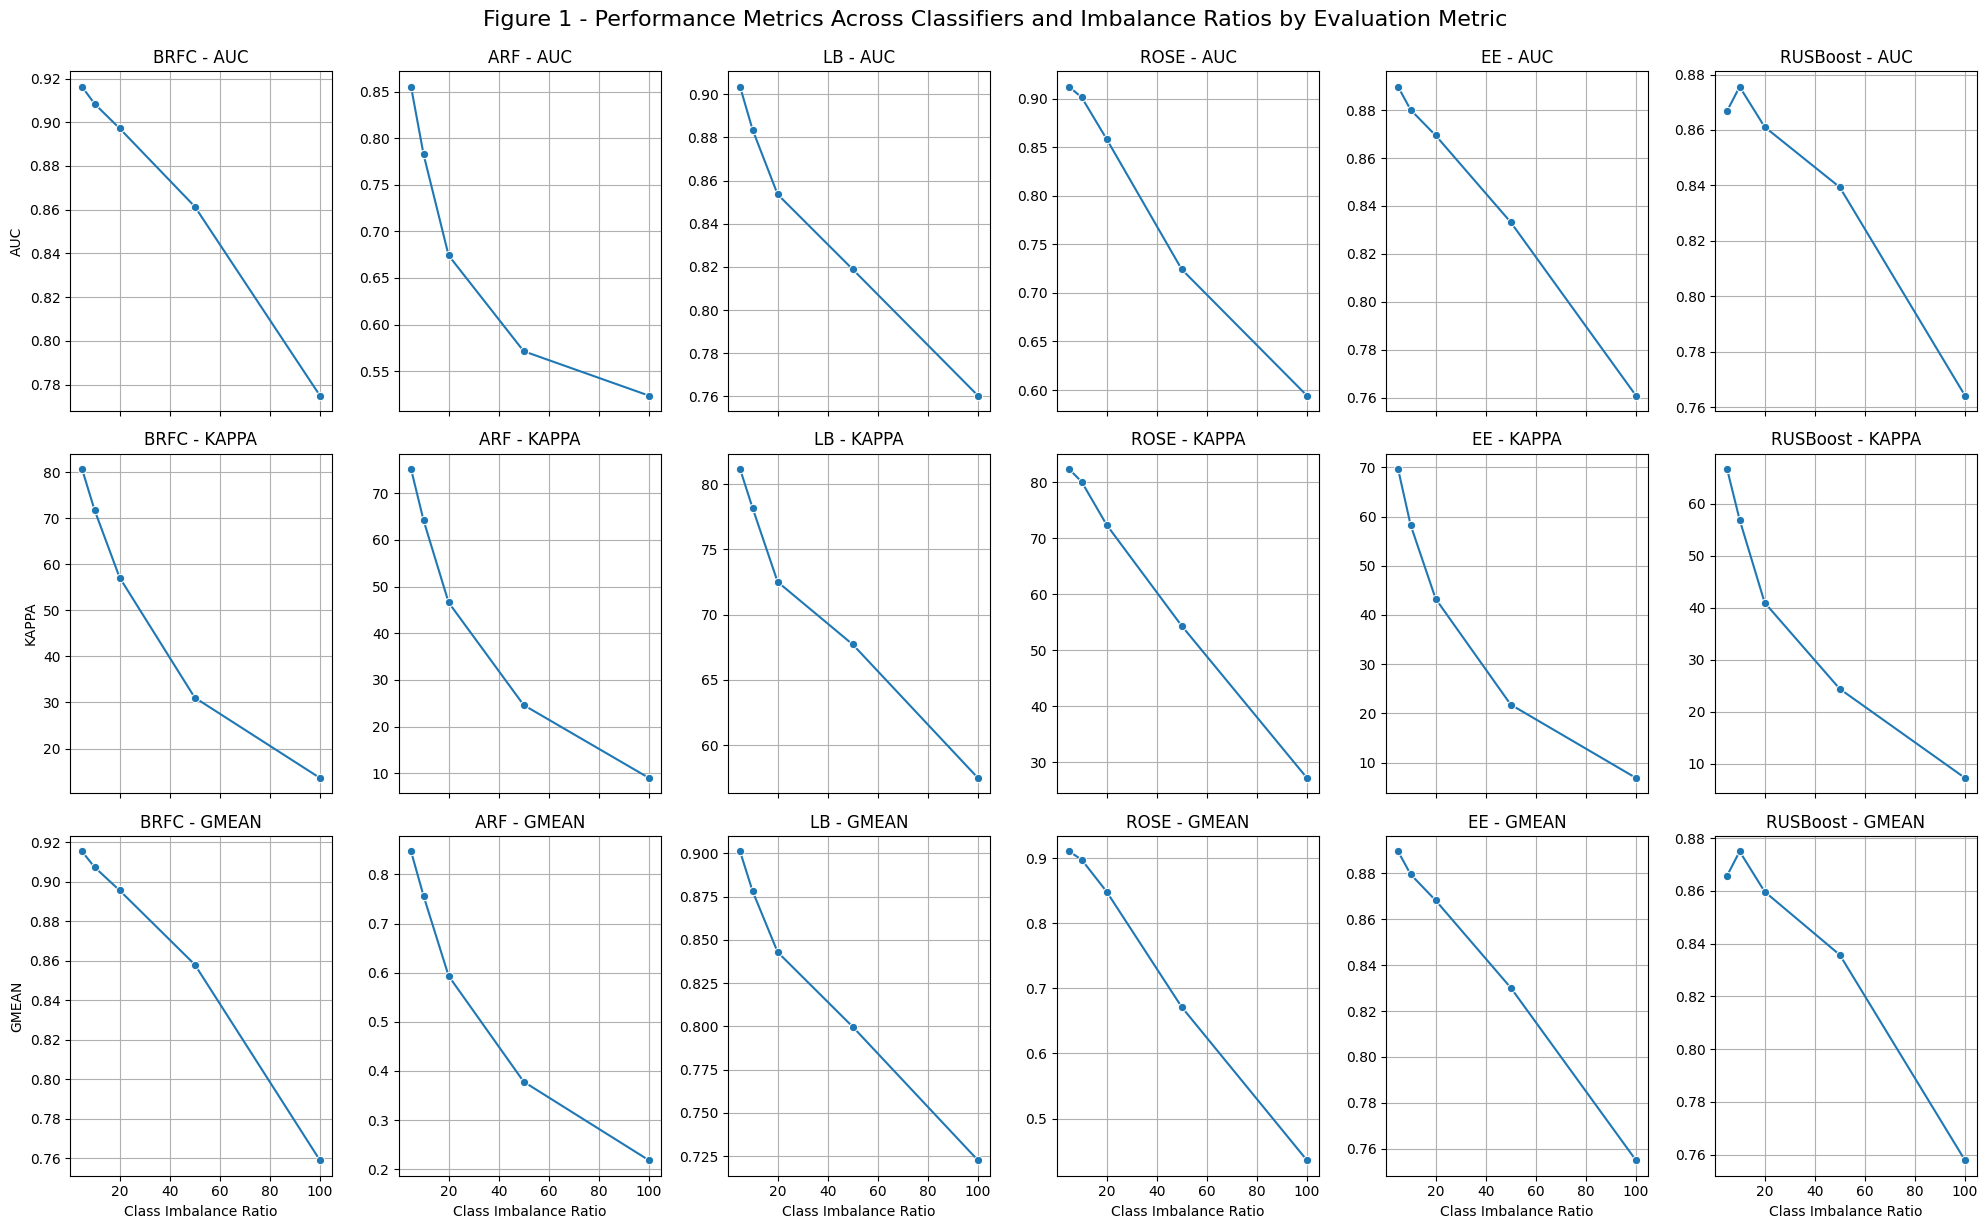

In [14]:
# Graph the results
metrics = ['auc', 'kappa', 'gmean']
classifiers = results_df['classifier'].unique()
ratios = sorted(results_df['ratio'].unique())

fig, axes = plt.subplots(len(metrics), len(classifiers), figsize=(20, 12), sharex=True, sharey=False)

for i, metric in enumerate(metrics):
    for j, classifier in enumerate(classifiers):
        ax = axes[i, j]
        subset = results_df[results_df['classifier'] == classifier]
        sns.lineplot(data=subset, x='ratio', y=metric, marker='o', ax=ax)
        ax.set_title(f"{classifier} - {metric.upper()}")
        ax.set_xlabel('Class Imbalance Ratio' if i == len(metrics) - 1 else "")
        ax.set_ylabel(metric.upper() if j == 0 else "")
        ax.grid(True)

plt.tight_layout()
plt.suptitle("Figure 1 - Performance Metrics Across Classifiers and Imbalance Ratios by Evaluation Metric", y=1.02, fontsize=16)
plt.show()

## Results
### Performance Metrics Analysis

The following Table 1 - Classifier Legend defines the classifiers used in this report to their alias used in the legend for plots and tables:


|Classifier|Legend|
|----------|-----------|
|Balanced Random Forest Classifier|BRFC|
|Adaptive Random Forest|ARF|
|Leverage Bagging|LB|
|Random Over Sample Examples|ROSE|
|Easy Ensemble|EE|
|RUSBoost|RUSBoost|

**Table 1 - Classifier Legend**

From Figure 1, there is an obvious degradation in classifier performance as the imbalance ratio increases from 5:1 to 100:1. This degradation can be see across the board in all evaluation metrics. 


|Imbalance Ratio|ARF|BRFC|EE|LB|ROSE|RUSBoost|Classifier Average|
|------------|---|----|--|--|----|--------|---------|
|5|0.84|**0.92**|0.89|0.90|0.91|0.87|0.89|
|10|0.79|**0.91**|0.88|0.88|0.90|0.88|0.87|
|20|0.67|**0.90**|0.87|0.88|0.86|0.86|0.84|
|50|0.59|**0.86**|0.83|0.83|0.72|0.84|0.76|
|100|0.55|0.77|0.76|**0.78**|0.59|0.76|0.68|

**Table 2 - AUC Results**


|Imbalance Ratio|ARF|BRFC|EE|LB|ROSE|RUSBoost|Classifier Average|
|------------|---|----|--|--|----|--------|---------|
|5|0.83|**0.92**|0.89|0.89|0.91|0.87|0.90|
|10|0.77|**0.91**|0.88|0.88|0.9|0.87|0.87|
|20|0.58|**0.90**|0.87|0.87|0.85|0.86|0.82|
|50|0.44|**0.86**|0.83|0.81|0.67|0.84|0.71|
|100|0.31|**0.76**|0.75|0.75|0.44|**0.76**|0.54|

**Table 3 - Geometric Mean Results**

|Imbalance Ratio|ARF|BRFC|EE|LB|ROSE|RUSBoost|Classifier Average|
|------------|---|----|--|--|----|--------|---------|
|5|72.89|80.66|69.64|80.27|**82.33**|66.72|77.49|
|10|64.05|71.77|58.29|78.17|**80.08**|56.97|70.48|
|20|46.26|57.12|43.28|**75.93**|72.37|40.99|58.26|
|50|30.86|31.05|21.76|**64.35**|54.32|24.39|39.86|
|100|17.24|13.61|6.87|**59.60**|27.16|7.25|21.03|

**Table 4 - Kappa Coefficient Results**

This degradation is further highlighted in Table 2 where for all classifiers for all performance metrics, there was a degrees in the evaluation measure corresponding to an increase in the imbalance ratio. The AUC metric displayed the least degradation amongst the evaluation measures implying that classifiers still maintain the ability to determine class separability even when data was extremely imbalanced. An AUC value of 0.5 signifies that a classifier's predictive power is no better than a chance guess. For the classifiers ARF (0.55 AUC) and ROSE (0.59 AUC), their AUC measure was close enough to the 0.5 point to indicate that at an imbalance ratio of 100:1 their predictive abilities are only marginally better than that of chance.



Given the previously defined Kappa measure scale for classifier performance as < 0 as indicating no agreement and 0–20 as slight, 21–40 as fair, 41–60 as moderate, 61–80 as substantial, and 81–100 for agreement, all classifiers start with either a great or substantial agreement with the ground truth for an imbalance ratio of 5:1. This agreement decreases across the board for the 100:1 imbalance ratio to either slight or fair agreement. There is one exception to this, the Leverage Bagging classifier, which achieved a moderate agreement with the ground truth.



For the geometric mean, all classifiers for the 5:1 imbalance ratio show excellent performance with an average score of 0.9 (1.0 being the highest). For the 100:1 imbalance ratio the picture is more mixed compared to the AUC and Kappa measures. BRFC, EE, LB and RUSBoost has geometric mean scores of 0.76, 0.75, 0.75 and 0.76. This means the classifiers generalised well for both classes. However ARF and ROSE had respective geometric scores of 0.31 and 0.44. This shows a severe imbalance in that the models failed to generalise for at least one class.


## Conclusion

This study evaluated six classifications algorithms that are designed to handle imbalanced datasets. Synthetic datasets with a binary target and with varying degrees of imbalance between the majority and minority classes were created with the imbalance ratios investigated being 5:1, 10:1, 20:1, 50:1 and 100:1. The key findings were:

* **Algorithm Robustness** - Leveraging Bagging (LB) and Balanced Random Forest (BRFC) were determined to the be two classifiers that were the most resilient as they maintained stable performance across increasing imbalance ratios.
* **Metric Sensitivity** - The Kappa Coefficient was the performance metric that was most susceptible to increases in imbalance ratios. This highlights the importance of using multiple evaluation measures to gain a truer picture of a classifiers performance under a range of conditions.

In this study we have quantified the relationship between imbalance ratios and classifier performance based on synthetic datasets. We have also shown performance metrics have themselves differing performance profiles when imbalanced datasets are utilised. 

Limitations of this study include the use on non real world, synthetic datasets. Real world datasets would be preferable in such a study as synthetic generation of datasets to match real world samples is itself an area of investigation. This study could also be improved by varying the number of features, the data types of the features and by having multiclass targets. Future research directions might include expansion of the classifers in consideration, dimensionality and data type complexity and automated methods to detect and adapt to imbalance data.

## Reference
1. Aguiar, G., Krawczyk, B., & Cano, A. (2023). A survey on learning from imbalanced data streams: Taxonomy, challenges, empirical study, and reproducible experimental framework. Machine Learning, 113(7), 4165–4243. https://doi.org/10.1007/s10994-023-06353-6
2. Wikipedia contributors. (2024, December 17). Receiver operating characteristic. In Wikipedia, The Free Encyclopedia. Retrieved 04:36, January 29, 2025, from https://en.wikipedia.org/w/index.php?title=Receiver_operating_characteristic&oldid=1263557992
3. Wikipedia contributors. (2024, September 13). Sensitivity and specificity. In Wikipedia, The Free Encyclopedia. Retrieved 04:47, January 29, 2025, from https://en.wikipedia.org/w/index.php?title=Sensitivity_and_specificity&oldid=1245547015
4. Cohen, Jacob (1960). "A coefficient of agreement for nominal scales". Educational and Psychological Measurement. 20 (1): 37–46. doi:10.1177/001316446002000104. hdl:1942/28116. S2CID 15926286.
5. Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830.
